# Analyzing the training Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RandomizedLasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

# print(train.info)

# Preprocessing and building the model with the training set

In [47]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


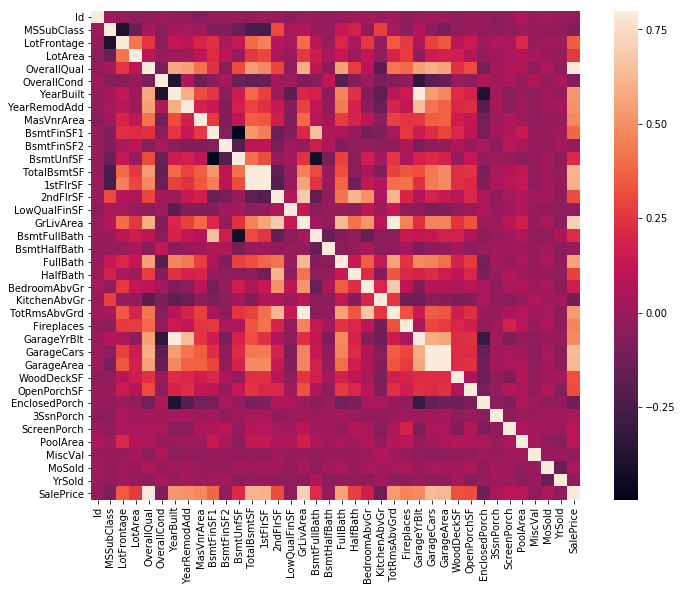

In [48]:
# Find correlation between SalePrice and other parameters

corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

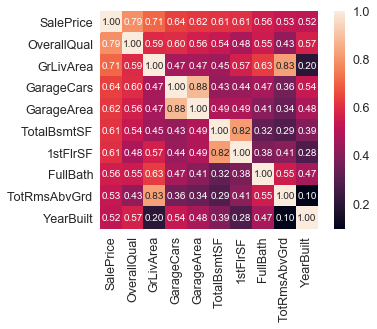

In [49]:
#saleprice correlation matrix for top 10 related parameters
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

In [3]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [4]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [5]:
df_train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [6]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


In [ ]:
# Get SalePrice column number
df_train.columns.get_loc('SalePrice')

In [ ]:
df_train[df_train.columns[62]].head()

In [7]:
# y is the class to be predicted aka SalePrice

y = df_train[df_train.columns[62]]
y.describe()

count      1459.000000
mean     180930.394791
std       79468.964025
min       34900.000000
25%      129950.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
# df_train_backup = df_train

In [8]:
# Getting training dataframe aka X by removing the last SalePrice column 

df_train = df_train.iloc[:, :62]
# df_train.columns.get_loc('SalePrice')
df_train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


# Dealing with dummies

In [13]:
train = df_train
test = df_test

In [14]:
all_data = pd.concat((train,test))
for column in all_data.select_dtypes(include=[np.object]).columns:
    train[column] = train[column].astype('category', categories = all_data[column].unique())
    test[column] = test[column].astype('category', categories = all_data[column].unique())
#     print(column, all_data[column].unique())


In [15]:
# Making dummies

X = pd.get_dummies(train)
X.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleType_0,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
0,1,60,8450,7,5,2003,2003,856,854,0,...,0,0,0,0,1,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,1262,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,60,11250,7,5,2001,2002,920,866,0,...,0,0,0,0,1,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,961,756,0,...,0,0,0,0,0,1,0,0,0,0
4,5,60,14260,8,5,2000,2000,1145,1053,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# df_train.head()

In [ ]:
# first_half = df_train.iloc[:,:34]
# first_half.head()
# second_half = df_train.iloc[:, 35:]
# second_half.head()

In [ ]:
# X = pd.concat([first_half, second_half])
# X.describe()

# Making the model

In [16]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0)  

# Create linear regression object
regressor = LinearRegression()  

# Train the model
regressor.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
# Predict

y_pred = regressor.predict(X_test)  
# df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})  
# df  

In [18]:
# Regression coefficients
train_coeffs = regressor.coef_
print(train_coeffs.shape)

(4300,)


In [19]:
# Variance score
print("Variance Score: ", regressor.score(X_test, y_test))

Variance Score:  0.758060811651206


# Analysis on the test dataset

In [9]:
df_test = pd.read_csv('test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
df_test.isnull().any()

In [ ]:
# cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageCond', 'GarageType',
#                 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond',
#                 'BsmtQual', 'MasVnrArea', 'MasVnrType']

In [ ]:
# df_test = df_test.drop(cols_to_drop, axis = 1)
# df_test.head()

In [10]:
#missing data
total_test = df_test.isnull().sum().sort_values(ascending=False)
percent_test = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
missing_data_test.head(50)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


In [11]:
#dealing with missing data
df_test = df_test.drop((missing_data[missing_data['Total'] > 4]).index,1)

# df_test = df_test.drop(df_test.loc[df_test['MSZoning'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['BsmtHalfBath'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['Utilities'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['Functional'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['BsmtFullBath'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['BsmtFinSF2'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['BsmtFinSF1'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['Exterior2nd'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['BsmtUnfSF'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['TotalBsmtSF'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['SaleType'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['Exterior1st'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['KitchenQual'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['GarageArea'].isnull()].index)
# df_test = df_test.drop(df_test.loc[df_test['GarageCars'].isnull()].index)

df_test.MSZoning.fillna('0',inplace = True)
df_test.BsmtHalfBath.fillna('0',inplace = True)
df_test.Utilities.fillna('0',inplace = True)
df_test.Functional.fillna('0',inplace = True)
df_test.BsmtFullBath.fillna('0',inplace = True)
df_test.BsmtFinSF2.fillna('0',inplace = True)
df_test.BsmtFinSF1.fillna('0',inplace = True)
df_test.Exterior2nd.fillna('0',inplace = True)
df_test.BsmtUnfSF.fillna('0',inplace = True)
df_test.TotalBsmtSF.fillna('0',inplace = True)
df_test.SaleType.fillna('0',inplace = True)
df_test.Exterior1st.fillna('0',inplace = True)
df_test.KitchenQual.fillna('0',inplace = True)
df_test.GarageArea.fillna('0',inplace = True)
df_test.GarageCars.fillna('0',inplace = True)


df_test.isnull().sum().max() #just checking thaBsmtHalfBatht there's no missing data missing...

0

In [12]:
df_test.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,82,0,0,144,0,0,1,2010,WD,Normal


In [20]:
# Making dummies

Y_test = pd.get_dummies(test)
Y_test.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleType_0,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
0,1461,20,11622,5,6,1961,1961,896,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1462,20,14267,6,6,1958,1958,1329,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1463,60,13830,5,5,1997,1998,928,701,0,...,0,0,0,0,1,0,0,0,0,0
3,1464,60,9978,6,6,1998,1998,926,678,0,...,0,0,0,0,1,0,0,0,0,0
4,1465,120,5005,8,5,1992,1992,1280,0,0,...,0,0,0,0,1,0,0,0,0,0


In [21]:
y_test_pred = regressor.predict(Y_test)
print(y_test_pred)

[ 99601.68266869 191636.094537   172517.91813416 ... 148990.28967411
 101291.00560658 250913.79075396]


In [22]:
print(type(y_test_pred))
print(y_test_pred.shape)

<class 'numpy.ndarray'>
(1459,)


In [31]:
# a = np.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
np.savetxt("foo.csv", np.dstack((np.arange(1, y_test_pred.size+1),y_test_pred))[0],"%d,%d",header="Id,SalePrice", newline=" ")

In [36]:
dt = pd.DataFrame(data=y_test_pred)
dt.to_csv('test_csv.csv', mode = 'w', index=True)

In [45]:
dt.index += 1461
dt

,0
1461,99601.682669
1462,191636.094537
1463,172517.918134
1464,191613.527802
1465,213594.529221
1466,176161.576632
1467,186242.079022
1468,154361.363825
1469,201899.097385
1470,123374.041527


In [40]:
result_dt = dt.reset_index()

In [42]:
result_dt['index'] += 1461
result_dt

,index,0
1461,1461,99601.682669
1462,1462,191636.094537
1463,1463,172517.918134
1464,1464,191613.527802
1465,1465,213594.529221
1466,1466,176161.576632
1467,1467,186242.079022
1468,1468,154361.363825
1469,1469,201899.097385
1470,1470,123374.041527


In [43]:
result_dt.to_csv('test2_csv.csv', mode = 'w', index=False)